<a href="https://colab.research.google.com/github/BURLAGADDA-AJAY-HARI-KRISHNA-221FA04286/AI-Mood-Based-Movie-Recommendation-System/blob/main/fake_news_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install -q transformers datasets evaluate accelerate


In [ ]:
!wget http://www.cs.ucsb.edu/~william/data/liar_dataset.zip
!unzip -q liar_dataset.zip -d liar_dataset
!ls liar_dataset


URL transformed to HTTPS due to an HSTS policy
--2025-08-21 16:16:14--  https://www.cs.ucsb.edu/~william/data/liar_dataset.zip
Resolving www.cs.ucsb.edu (www.cs.ucsb.edu)... 23.185.0.253, 2620:12a:8001::253, 2620:12a:8000::253
Connecting to www.cs.ucsb.edu (www.cs.ucsb.edu)|23.185.0.253|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://sites.cs.ucsb.edu/~william/data/liar_dataset.zip [following]
--2025-08-21 16:16:14--  https://sites.cs.ucsb.edu/~william/data/liar_dataset.zip
Resolving sites.cs.ucsb.edu (sites.cs.ucsb.edu)... 128.111.27.164
Connecting to sites.cs.ucsb.edu (sites.cs.ucsb.edu)|128.111.27.164|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1013571 (990K) [application/zip]
Saving to: ‘liar_dataset.zip.1’

liar_dataset.zip.1  100%[===================>] 989.82K  5.96MB/s    in 0.2s    

2025-08-21 16:16:15 (5.96 MB/s) - ‘liar_dataset.zip.1’ saved [1013571/1013571]

replace liar_dataset/README? [y]es, 

In [ ]:
from datasets import load_dataset

column_names = [
    "id", "label", "statement", "subject", "speaker", "job_title", "state",
    "party", "barely_true_counts", "false_counts", "half_true_counts",
    "mostly_true_counts", "pants_on_fire_counts", "context"
]

dataset = load_dataset(
    "csv",
    data_files={
        "train": "liar_dataset/train.tsv",
        "validation": "liar_dataset/valid.tsv",
        "test": "liar_dataset/test.tsv"
    },
    delimiter="\t",
    column_names=column_names
)

print(dataset)


DatasetDict({
    train: Dataset({
        features: ['id', 'label', 'statement', 'subject', 'speaker', 'job_title', 'state', 'party', 'barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts', 'context'],
        num_rows: 10240
    })
    validation: Dataset({
        features: ['id', 'label', 'statement', 'subject', 'speaker', 'job_title', 'state', 'party', 'barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts', 'context'],
        num_rows: 1284
    })
    test: Dataset({
        features: ['id', 'label', 'statement', 'subject', 'speaker', 'job_title', 'state', 'party', 'barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts', 'context'],
        num_rows: 1267
    })
})


In [ ]:
label_map = {
    "pants-fire": 0,
    "false": 0,
    "barely-true": 0,
    "half-true": 0,
    "mostly-true": 1,
    "true": 1
}

def to_binary(example):
    return {"labels": label_map[example["label"]]}

dataset = dataset.map(to_binary)
print(dataset["train"][0])


Map:   0%|          | 0/10240 [00:00<?, ? examples/s]

Map:   0%|          | 0/1284 [00:00<?, ? examples/s]

Map:   0%|          | 0/1267 [00:00<?, ? examples/s]

{'id': '2635.json', 'label': 'false', 'statement': 'Says the Annies List political group supports third-trimester abortions on demand.', 'subject': 'abortion', 'speaker': 'dwayne-bohac', 'job_title': 'State representative', 'state': 'Texas', 'party': 'republican', 'barely_true_counts': 0.0, 'false_counts': 1.0, 'half_true_counts': 0.0, 'mostly_true_counts': 0.0, 'pants_on_fire_counts': 0.0, 'context': 'a mailer', 'labels': 0}


In [ ]:
from transformers import AutoTokenizer

model_checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

def tokenize_fn(batch):
    return tokenizer(batch["statement"], truncation=True, padding="max_length", max_length=128)

train_tok = dataset["train"].map(tokenize_fn, batched=True)
val_tok   = dataset["validation"].map(tokenize_fn, batched=True)
test_tok  = dataset["test"].map(tokenize_fn, batched=True)

# Set format for PyTorch
train_tok.set_format(type="torch", columns=["input_ids","attention_mask","labels"])
val_tok.set_format(type="torch", columns=["input_ids","attention_mask","labels"])
test_tok.set_format(type="torch", columns=["input_ids","attention_mask","labels"])


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/10240 [00:00<?, ? examples/s]

Map:   0%|          | 0/1284 [00:00<?, ? examples/s]

Map:   0%|          | 0/1267 [00:00<?, ? examples/s]

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding
import evaluate
import numpy as np

num_labels = 2
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)
model.config.id2label = {0: "fake", 1: "real"}
model.config.label2id = {"fake": 0, "real": 1}

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy.compute(predictions=preds, references=labels)["accuracy"],
        "f1": f1.compute(predictions=preds, references=labels, average="binary")["f1"]
    }


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
!pip install --upgrade -q transformers datasets evaluate


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 41.4 MB/s eta 0:00:00


In [ ]:
!pip install --upgrade -q transformers datasets evaluate


In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tok,
    eval_dataset=val_tok,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()

/tmp/ipython-input-2199331881.py:14: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: 221fa04286 (221fa04286-vignan-s-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.626700,0.593808,0.679907,0.475096


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.626700,0.593808,0.679907,0.475096
2,0.588000,0.598308,0.669003,0.478528
3,0.511700,0.644631,0.674455,0.482673


TrainOutput(global_step=1920, training_loss=0.5523033618927002, metrics={'train_runtime': 621.0015, 'train_samples_per_second': 49.468, 'train_steps_per_second': 3.092, 'total_flos': 1017349621678080.0, 'train_loss': 0.5523033618927002, 'epoch': 3.0})

In [ ]:
print(trainer.evaluate(eval_dataset=test_tok))

from transformers import pipeline
clf = pipeline("text-classification", model=trainer.model, tokenizer=tokenizer)
sample = "The pandemic is completely over, scientists say."
print(clf(sample))


Device set to use cuda:0


{'eval_loss': 0.6550763845443726, 'eval_accuracy': 0.6519337016574586, 'eval_f1': 0.48899188876013905, 'eval_runtime': 4.5277, 'eval_samples_per_second': 279.835, 'eval_steps_per_second': 8.835, 'epoch': 3.0}
[{'label': 'fake', 'score': 0.9505428075790405}]


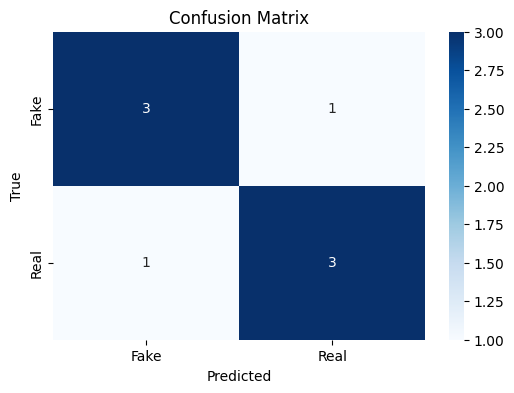


Classification Report:

              precision    recall  f1-score   support

        Fake       0.75      0.75      0.75         4
        Real       0.75      0.75      0.75         4

    accuracy                           0.75         8
   macro avg       0.75      0.75      0.75         8
weighted avg       0.75      0.75      0.75         8



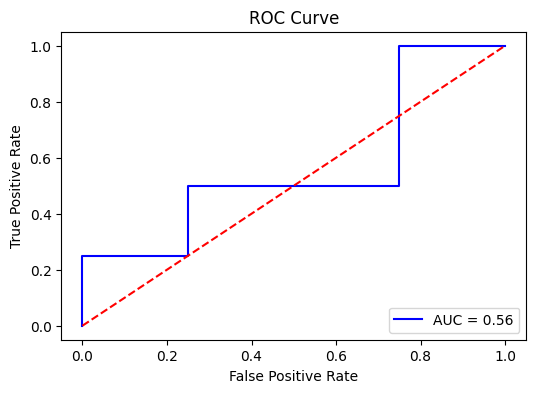

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import numpy as np

# Example: true labels and predictions from your model
y_true = [0, 1, 1, 0, 1, 0, 1, 0]   # Replace with real labels
y_pred = [0, 1, 0, 0, 1, 0, 1, 1]   # Replace with predicted labels

# ✅ Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# ✅ Classification Report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=["Fake", "Real"]))

# ✅ ROC Curve
y_prob = np.random.rand(len(y_true))  # replace with your model prediction probabilities
fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, color="blue", label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1], [0,1], color="red", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()


In [2]:
!git config --global user.name "BURLAGADDA AJAY HARI KRISHNA"
!git config --global user.email "ajayburlagadda@gmail.com"


In [8]:
!git clone https://github.com/BURLAGADDA-AJAY-HARI-KRISHNA-221FA04286/fake-news-detection.git
%cd fake-news-detection

Cloning into 'fake-news-detection'...
/content/fake-news-detection


In [9]:
!cp /content/fake_news_detection.ipynb ./  # example
!cp -r /content/model ./             # if you have model folder

cp: cannot stat '/content/fake_news_detection.ipynb': No such file or directory
cp: cannot stat '/content/model': No such file or directory
